<p style="font-size:18px; font-family:open sans; line-height:1.2"> This notebook implements Fast Gradient Sign Method for a model trained on MNIST dataset. The training code used in this notebook is stolen from <a href="https://github.com/pytorch/examples/blob/master/mnist/main.py">here</a>. This notebook doesn't contain explanation of theory behind FGSM, if you are interested in learning more check out <a href="https://github.com/savan77/Generating-Adversarial-Examples-with-PyTorch/blob/master/imagenet_adv_examples.ipynb">this notebook</a>. It explains theory behind methods and also implements more method (for InceptionV3 model) than this notebook does.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
import torchvision
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

batch_size = 64
test_batch_size = 1000
epochs = 5
lr = 0.01
momentum = 0.5
seed = 1
log_interval = 10
cuda = False

torch.manual_seed(seed)


kwargs = {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376790
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.332813
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.291239
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.253216
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.234785
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.259442
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.200626
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.116516
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.170818
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011620
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.004478
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.710951
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.747870
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.662681
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.776260
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.577364
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.334061
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.284160
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.349092
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.152377
Train Epoch: 1 [12800/60000 (

In [39]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.view(28,28)
    x = x.mul(torch.FloatTensor([0.3081,])).add(torch.FloatTensor([0.1307,])).numpy()#reverse of normalization op- "unnormalize"
    
    x_adv = x_adv.view(28,28)
    x_adv = x_adv.mul(torch.FloatTensor([0.3081,])).add(torch.FloatTensor([0.1307,])).numpy()#reverse of normalization op
    
    x_grad = x_grad.view(28,28).numpy()
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

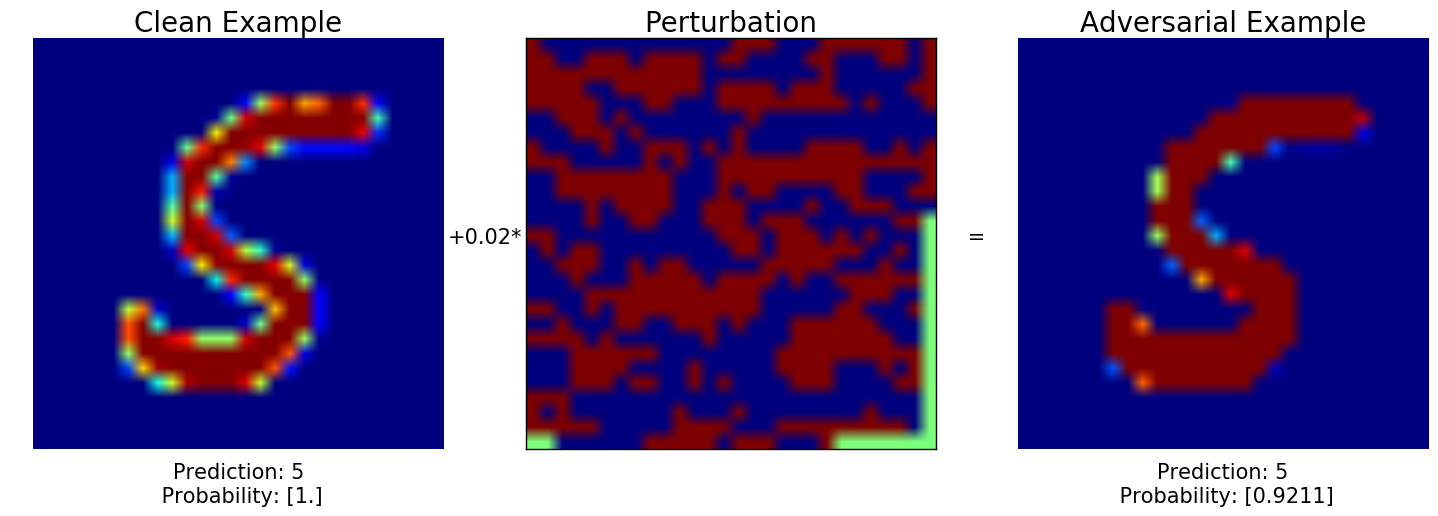

In [40]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
x = images[7]  #take one image
t = labels[7]  #take corresponding label
x = torch.Tensor(x)
x.unsqueeze_(0)
x = Variable(x, requires_grad=True)

target = Variable(torch.LongTensor([t]), requires_grad=False)

output = model(x)
x_pred = torch.max(output.data, 1)[1][0]
#output is log_softmax so in order to get probs take 'exp' of it.
output_probs = np.exp(output.data)
prob= output_probs[:,x_pred]

loss = F.nll_loss(output, target)
loss.backward()
#generate the adversarial example using formula, also clip it to make it a valid image
epsilon = 0.02
x_grad = torch.sign(x.grad.data)
x_adversarial = torch.clamp(x.data + epsilon * x_grad, 0, 1)

out2 = model(Variable(x_adversarial))
adv_pred = torch.max(out2.data,1)[1][0]

out_adv_probs = np.exp(out2.data)
prob_adv = out_adv_probs[:,adv_pred]

visualize(x.data, x_adversarial, x_grad, epsilon, x_pred, adv_pred,np.around(prob.numpy(),4), np.around(prob_adv.numpy(),4))
